In [1]:
import numpy as np
import xarray as xr

### Preliminaries

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/cmip6/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/cmip6/cil-gdpcir/'

In [3]:
###################
# Models
###################

# nex models with all SSPs and variables (tas, pr)
complete_nex_models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'CanESM5', 'CMCC-ESM2', 
                       'CNRM-CM6-1', 'CNRM-ESM2-1', 'EC-Earth3',
                       'EC-Earth3-Veg-LR', 'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 
                       'GISS-E2-1-G', 'INM-CM4-8', 'INM-CM5-0',
                       'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC-ES2L', 'MIROC6',
                       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM',
                       'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']

# cil models with all SSPs and variables
complete_cil_models = ["INM-CM4-8", "INM-CM5-0", "BCC-CSM2-MR", "CMCC-CM2-SR5",
              "CMCC-ESM2", "MIROC-ES2L", "MIROC6", "UKESM1-0-LL", "MPI-ESM1-2-LR",
              "NorESM2-LM", "NorESM2-MM", "GFDL-ESM4", "EC-Earth3", 
              "EC-Earth3-Veg-LR", "EC-Earth3-Veg", "CanESM5"]

# intersection of models
models = np.intersect1d(complete_cil_models, complete_nex_models)

In [4]:
######################################
# Prep each ensemble for merge
######################################
def preprocess_nex(ds):
    ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
    ds = ds.sortby('lon')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(ensemble = 'NEX')
    ds = ds.assign_coords(model = ds.encoding['source'][93:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

def preprocess_cil(ds):
    ds = ds.rename({'tasavg':'tas'})
    ds = ds.sel(lat=slice(-60, 90))
    ds = ds.assign_coords(ensemble = 'CIL')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(model = ds.encoding['source'][95:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

In [7]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=1, memory='20GB', resource_spec = 'pmem=20GB',
                     project='open',
                     env_extra=['#PBS -l feature=rhel7'], 
                     walltime='00:10:00')

cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.239:43036,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Annual averages

In [8]:
# NEX
ds_nex = xr.open_mfdataset(nex_in + '/annual_avgs/*', preprocess=preprocess_nex,
                           combine='nested', concat_dim='model',
                           chunks='auto', compat='identical')

In [9]:
# CIL
ds_cil = xr.open_mfdataset(cil_in + '/annual_avgs/*', preprocess=preprocess_cil,
                           combine='nested', concat_dim='model',
                           chunks='auto', compat='identical')

ds_cil['tas'] = ds_cil['tas'] - 273.15 # K -> C
ds_cil['tasmax'] = ds_cil['tasmax'] - 273.15 # K -> C
ds_cil['tasmin'] = ds_cil['tasmin'] - 273.15 # K -> C

In [10]:
# merge all
ds = xr.concat([ds_nex, ds_cil], dim='ensemble', compat='equals')

In [11]:
# Select a point of interest
ds_test = ds.sel(lat=40, lon=-88, method='nearest') # near CU

In [12]:
###########################
####### HS09 method #######
###########################

# Model uncertainty: variance across models, averaged over scenarios and ensembles
Umod = ds_test.var(dim='model').mean(dim=['ssp', 'ensemble']).compute()

# Scenario uncertainty STANDARD (HS09): variance across multi-model means
Uscen = ds_test.mean(dim=['model', 'ensemble']).var(dim='ssp').compute()

# Scenario uncertainty LEE
Uscen_lee = ds_test.var(dim=['model', 'ensemble']).mean(dim='ssp').compute()

# Downscaling uncertainy: variance across ensembles, averaged over models and scenarios
Udown = ds_test.var(dim='ensemble').mean(dim=['ssp', 'model']).compute()

# Total uncertainty
Utotal = ds_test.var(dim=['ensemble', 'ssp', 'model']).compute()

In [13]:
# store for later
ds_out_test = [Umod,
               Uscen, Uscen_lee,
               Udown,
               Utotal]

In [14]:
import matplotlib.pyplot as plt

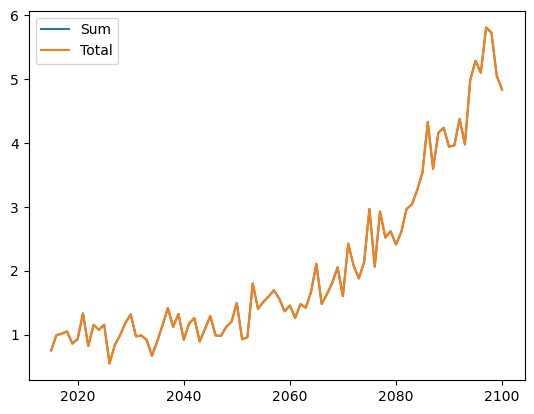

In [15]:
fig, ax = plt.subplots()
yrs = np.arange(2015, 2101)

ax.plot(yrs, Uscen.tas.to_numpy() + Uscen_lee.tas.to_numpy(), label='Sum')
ax.plot(yrs, Utotal.tas.to_numpy(), label='Total')

ax.legend()
plt.show()

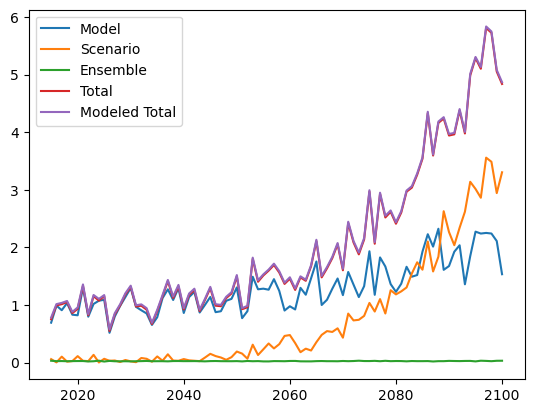

In [18]:
fig, ax = plt.subplots()
yrs = np.arange(2015, 2101)

ax.plot(yrs, Umod.tas.to_numpy(), label='Model')
ax.plot(yrs, Uscen.tas.to_numpy(), label='Scenario')
ax.plot(yrs, Udown.tas.to_numpy(), label='Ensemble')
ax.plot(yrs, Utotal.tas.to_numpy(), label='Total')

Utotal_model = Uscen.tas.to_numpy() + Udown.tas.to_numpy() + Umod.tas.to_numpy()
ax.plot(yrs, Utotal_model, label='Modeled Total')

ax.legend()
plt.show()

In [ ]:
###########################
####### K19 method ########
###########################
# ds_test = ds_test.load()

# Scenario uncertainty: variance across scenarios, averaged over models and ensembles
U_scen = ds_test.var(dim='ssp').mean(dim=['model', 'ensemble'])

# Model uncertainty
U_scen_model = ds_test.var(dim=['ssp', 'model']).mean(dim='ensemble')
U_model = U_scen_model - U_scen

# Downscaling uncertainy
U_scen_model_down = ds_test.var(dim=['ensemble', 'ssp', 'model'])
U_down = U_scen_model_down - U_scen_model

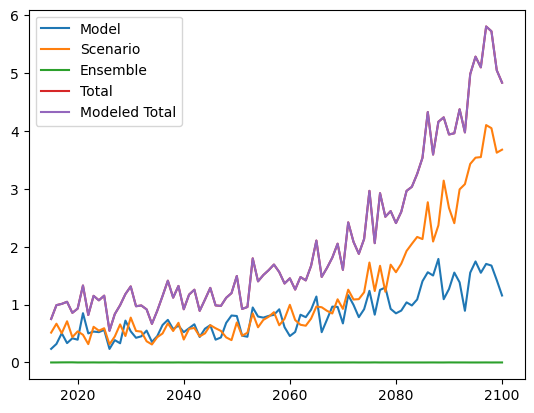

In [25]:
fig, ax = plt.subplots()
yrs = np.arange(2015, 2101)

ax.plot(yrs, U_model.tas.to_numpy(), label='Model')
ax.plot(yrs, U_scen.tas.to_numpy(), label='Scenario')
ax.plot(yrs, U_down.tas.to_numpy(), label='Ensemble')
ax.plot(yrs, U_scen_model_down.tas.to_numpy(), label='Total')

Utotal_model = U_model.tas.to_numpy() + U_scen.tas.to_numpy() + U_down.tas.to_numpy()
ax.plot(yrs, Utotal_model, label='Modeled Total')

ax.legend()
plt.show()